# Fine-tuning InceptionV3 for flowers classification

In this task you will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html):
<img src="images/inceptionv3.png" style="width:70%">

Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="images/flowers.jpg" style="width:70%">

# Import stuff

In [1]:
import sys
sys.path.append("..")
import grading
import download_utils

In [2]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [3]:
download_utils.link_all_keras_resources()

In [4]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
# print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import tqdm
import keras_utils

1.8.0


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [5]:
from tensorflow.python.keras import backend as K

In [6]:
grader = grading.Grader(assignment_key="2v-uxpD7EeeMxQ6FWsz5LA", 
                        all_parts=["wuwwC", "a4FK1", "qRsZ1"])

In [30]:
# token expires every 30 min
COURSERA_TOKEN = ValueError()
COURSERA_EMAIL = "aaron.tillekeratne@gmail.com"

# Load dataset

Dataset was downloaded for you, it takes 12 min and 400mb.
Relevant links (just in case):
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

In [9]:
# we downloaded them for you, just link them here
download_utils.link_week_3_resources()

# Prepare images for model

In [10]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 250

In [11]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

We will take a center crop from each image like this:
<img src="images/center_crop.jpg" style="width:50%">

In [21]:
def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    z = min(img.shape[0],img.shape[1])
    center_h = img.shape[0]//2
    center_w = img.shape[1]//2
    start_h = center_h - (z//2)
    end_h = center_h + (z//2)
    start_w = center_w - (z//2)
    end_w = center_w + (z//2)
    cropped_img = img[start_h:end_h,start_w:end_w,:]
    
    return cropped_img

In [26]:
arr = np.ndarray([255,250,3])
image_center_crop(arr).shape

(250, 250, 3)

In [27]:
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

In [28]:
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 591, 3)


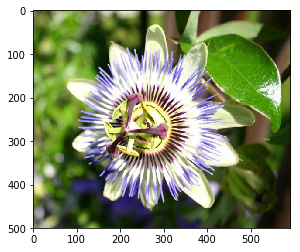

(250, 250, 3)


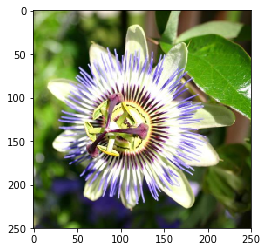

In [29]:
# test cropping
raw_bytes = read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

In [32]:
## GRADED PART, DO NOT CHANGE!
# Test image preparation for model
prepared_img = prepare_raw_bytes_for_model(read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg"))
grader.set_answer("qRsZ1", list(prepared_img.shape) + [np.mean(prepared_img), np.std(prepared_img)])

In [33]:
# you can make submission with answers so far to check yourself at this stage
COURSERA_TOKEN = "Y9JXDg0A5lBrINNc"
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Prepare for training

In [34]:
# read all filenames and labels for them

# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames("102flowers.tgz"))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1  # read class labels (0, 1, 2, ...)
# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [35]:
# split into train/test
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [36]:
# will yield raw image bytes from tar with corresponding label
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        while True:
            m = f.next()
            if m is None:
                break
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [49]:
# batch generator
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). You should do `for item in items: ...`
        In case of generator you can pass through your items only once!
    Output: In output yield each batch as a list of items.
    """
    import copy
    _local = copy.deepcopy(list(items))
    while _local:
        yield [_local.pop() for x in range(min(batch_size,len(_local)))]

In [50]:
x = np.random.randn(1000).tolist()
z = batch_generator(x,32)

In [51]:
## GRADED PART, DO NOT CHANGE!
# Test batch generator
def _test_items_generator():
    for i in range(10):
        yield i

grader.set_answer("a4FK1", list(map(lambda x: len(x), batch_generator(_test_items_generator(), 3))))

In [52]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, "aKNFgbvnUYLOnbg3")

Submitted to Coursera platform. See results on assignment page!


In [56]:
from tensorflow.python.keras.utils import to_categorical
def train_generator(files, labels):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(raw_generator_with_label_from_tar(
                "102flowers.tgz", files, labels), BATCH_SIZE):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

(32, 250, 250, 3) (32, 102)


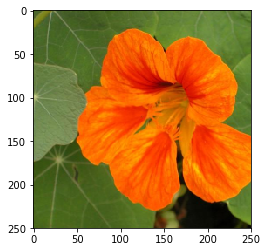

In [57]:
# test training generator
for _ in train_generator(tr_files, tr_labels):
    print(_[0].shape, _[1].shape)
    plt.imshow(np.clip(_[0][0] / 2. + 0.5, 0, 1))
    break

# Training

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [58]:
# remember to clear session if you start building graph from scratch!
s = reset_tf_session()
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

In [61]:
from tensorflow.python.keras import Model
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = Model(model.inputs, new_output)
    return model

In [62]:
model = inception()

In [63]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 124, 124, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 124, 124, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 124, 124, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [64]:
# how many layers our model has
print(len(model.layers))

313


In [65]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False

In [68]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.Adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [76]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'flowers.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
from tensorflow.python.keras.models import load_model
s = reset_tf_session()
last_finished_epoch = 19
model = load_model(model_filename.format(last_finished_epoch))

Training takes **2 hours**. You're aiming for ~0.93 validation accuracy.

In [ ]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    epochs=2 * 50,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    callbacks=[keras_utils.TqdmProgressCallback(), 
               keras_utils.ModelSaveCallback(model_filename)],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Epoch 16/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.015.hdf5
Epoch 17/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.016.hdf5
Epoch 18/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.017.hdf5
Epoch 19/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.018.hdf5
Epoch 20/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.019.hdf5
Epoch 21/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.020.hdf5
Epoch 22/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.021.hdf5
Epoch 23/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.022.hdf5
Epoch 24/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.023.hdf5
Epoch 25/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.024.hdf5
Epoch 26/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.025.hdf5
Epoch 27/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.026.hdf5
Epoch 28/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.027.hdf5
Epoch 29/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.028.hdf5
Epoch 30/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.029.hdf5
Epoch 31/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.030.hdf5
Epoch 32/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.031.hdf5
Epoch 33/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.032.hdf5
Epoch 34/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.033.hdf5
Epoch 35/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.034.hdf5
Epoch 36/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.035.hdf5
Epoch 37/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.036.hdf5
Epoch 38/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.037.hdf5
Epoch 39/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.038.hdf5
Epoch 40/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.039.hdf5
Epoch 41/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.040.hdf5
Epoch 42/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.041.hdf5
Epoch 43/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.042.hdf5
Epoch 44/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.043.hdf5
Epoch 45/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.044.hdf5
Epoch 46/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.045.hdf5
Epoch 47/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.046.hdf5
Epoch 48/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.047.hdf5
Epoch 49/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.048.hdf5
Epoch 50/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.049.hdf5
Epoch 51/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.050.hdf5
Epoch 52/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.051.hdf5
Epoch 53/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.052.hdf5
Epoch 54/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.053.hdf5
Epoch 55/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.054.hdf5
Epoch 56/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.055.hdf5
Epoch 57/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.056.hdf5
Epoch 58/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.057.hdf5
Epoch 59/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.058.hdf5
Epoch 60/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.059.hdf5
Epoch 61/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.060.hdf5
Epoch 62/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.061.hdf5
Epoch 63/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.062.hdf5
Epoch 64/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.063.hdf5
Epoch 65/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.064.hdf5
Epoch 66/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.065.hdf5
Epoch 67/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.066.hdf5
Epoch 68/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.067.hdf5
Epoch 69/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.068.hdf5
Epoch 70/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.069.hdf5
Epoch 71/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.070.hdf5
Epoch 72/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.071.hdf5
Epoch 73/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.072.hdf5
Epoch 74/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.073.hdf5
Epoch 75/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.074.hdf5
Epoch 76/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.075.hdf5
Epoch 77/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.076.hdf5
Epoch 78/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.077.hdf5
Epoch 79/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.078.hdf5
Epoch 80/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.079.hdf5
Epoch 81/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.080.hdf5
Epoch 82/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.081.hdf5
Epoch 83/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.082.hdf5
Epoch 84/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.083.hdf5
Epoch 85/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.084.hdf5
Epoch 86/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.085.hdf5
Epoch 87/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.086.hdf5
Epoch 88/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.087.hdf5
Epoch 89/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.088.hdf5
Epoch 90/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.089.hdf5
Epoch 91/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.090.hdf5
Epoch 92/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.091.hdf5
Epoch 93/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.092.hdf5
Epoch 94/100


Widget Javascript not detected.  It may not be installed or enabled properly.



Model saved in flowers.093.hdf5
Epoch 95/100


Widget Javascript not detected.  It may not be installed or enabled properly.


In [78]:
## GRADED PART, DO NOT CHANGE!
# Accuracy on validation set
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]
grader.set_answer("wuwwC", test_accuracy)
print(test_accuracy)

0.47


In [72]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, "aKNFgbvnUYLOnbg3")

Submitted to Coursera platform. See results on assignment page!


That's it! Congratulations!

What you've done:
- prepared images for the model
- implemented your own batch generator
- fine-tuned the pre-trained model